<a href="https://colab.research.google.com/github/MANOJ-S-NEGI/SENTIMENT_ANALYSIS_NLP/blob/main/sentiments_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, nltk
import seaborn as sns
import string
nltk.download('punkt')
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
df= pd.read_csv("/content/sentiment_analysis_clean_lemitized_data.csv")

In [3]:
df.sample(3)

,target,reviews
2117,neutral,southwestair ive never meet favorite band woul...
5515,positive,southwestair good beers oscars ar dia
1164,negative,americanair cancel flight flight jfk delay us ...


In [4]:
# seperating feature and target column:
x = df['reviews']

# Create a mapping dictionary
sentiment_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}
# Apply the mapping using the 'map' function
y = df['target'].map(sentiment_mapping)

In [5]:
x_token_frame = x.copy()

In [6]:
counter = 0
for text in x:
    split_word = []
    for split in text.split():
        split_word.append(split)
    # Join and tokenize
    tokenize_sentence = nltk.word_tokenize(' '.join(split_word))
    x_token_frame[counter] = tokenize_sentence.copy()
    counter = counter+1

In [7]:
x_token_frame.sample()

334    [usairways, sorry, try, add, day, vacation, ch...
Name: reviews, dtype: object

In [8]:
### integer encoding using keras:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token = '')
tokenizer.fit_on_texts(x_token_frame)

In [9]:
## performing the split:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_token_frame, y, test_size=0.10)

print(f"x_train shape {x_train.shape} x_train_length: {len(x_train)}")
print(f"y_train shape {y_train.shape} y_train_length: {len(y_train)}")

print(f"x_test shape {x_test.shape} x_test_length: {len(x_test)}")
print(f"y_test shape {y_test.shape} y_test_length: {len(y_test)}")

x_train shape (5400,) x_train_length: 5400
y_train shape (5400,) y_train_length: 5400
x_test shape (600,) x_test_length: 600
y_test shape (600,) y_test_length: 600


In [10]:
# searching max length and vocab size

# findind input dim:
vocab_size = len(tokenizer.word_index)
vocab_size = vocab_size+1
print(f"Vocabulary size: {vocab_size}")




# searching max length:
max_seq_length = 0
for sentence in x_train:
    current_length = len(sentence)
    if current_length > max_seq_length:
        max_seq_length = current_length

print("max_seq_length", max_seq_length)

Vocabulary size: 7196
max_seq_length 22


In [11]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [12]:
## paddding the each rows :
from keras.utils import pad_sequences

x_train = pad_sequences(x_train, maxlen=max_seq_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_seq_length, padding='post')
print(f"x_train shape {x_train.shape}\n x_train_length: {len(x_train)}")
print(f"y_train shape {y_train.shape}\n y_train_length: {len(y_train)}")


x_train shape (5400, 22)
 x_train_length: 5400
y_train shape (5400,)
 y_train_length: 5400


In [13]:
x_train[:2]

array([[   3,  218,   13, 3533,    2,  365,  994,   65,  634,  254,   43,
         364,   48,   15,    2,  312,    0,    0,    0,    0,    0,    0],
       [   3, 1677,  898,   54,  194,  135,   20,   41,   26,  242,  127,
         111,  141,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [14]:
## converting into numpy:

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [15]:
## creating sequential model layers:
model_sentiments = tf.keras.Sequential([

    tf.keras.layers.Embedding(input_dim = 7196 , output_dim=3, input_length = max_seq_length ),
    tf.keras.layers.LSTM(100,dropout=0.2, activation='relu', return_sequences = True),  # Added return_sequences=True
     tf.keras.layers.SpatialDropout1D(rate=0.3),
    tf.keras.layers.LSTM(100, dropout=0.2, activation='relu', return_sequences = False),  # Added return_sequences=True

    tf.keras.layers.Dense(3, activation='softmax')

])


## model summary:
model_sentiments.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 3)             21588     
                                                                 
 lstm (LSTM)                 (None, 22, 100)           41600     
                                                                 
 spatial_dropout1d (Spatial  (None, 22, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 143891 (562.07 KB)
Trainable params: 143891 (562.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [16]:
# Create a function to implement a Earlystop callback with loss monitor)
Early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience = 3, verbose = 2)

## model compiling :
optimize = tf.keras.optimizers.experimental.Adam(learning_rate=0.0001)
model_sentiments.compile(optimizer= optimize, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [17]:
# fitting the model:
history = model_sentiments.fit(x_train,y_train,
                  validation_data=(x_test, y_test),
                  batch_size=32,
                  epochs=30,
                  callbacks=Early_stop)


Epoch 1/30
169/169 [==============================] - 10s 43ms/step - loss: 1.0984 - accuracy: 0.3389 - val_loss: 1.0975 - val_accuracy: 0.4367
Epoch 2/30
169/169 [==============================] - 8s 45ms/step - loss: 1.0572 - accuracy: 0.4330 - val_loss: 0.9533 - val_accuracy: 0.5050
Epoch 3/30
169/169 [==============================] - 8s 49ms/step - loss: 0.9393 - accuracy: 0.5178 - val_loss: 0.9109 - val_accuracy: 0.5300
Epoch 4/30
169/169 [==============================] - 7s 39ms/step - loss: 0.8788 - accuracy: 0.5617 - val_loss: 0.8688 - val_accuracy: 0.5700
Epoch 5/30
169/169 [==============================] - 4s 23ms/step - loss: 0.8423 - accuracy: 0.5922 - val_loss: 0.8496 - val_accuracy: 0.5900
Epoch 6/30
169/169 [==============================] - 4s 26ms/step - loss: 0.7955 - accuracy: 0.6369 - val_loss: 0.8283 - val_accuracy: 0.6100
Epoch 7/30
169/169 [==============================] - 4s 22ms/step - loss: 0.7624 - accuracy: 0.6474 - val_loss: 0.8232 - val_accuracy: 0.598

In [18]:
prediction = model_sentiments.predict(x_test)

19/19 [==============================] - 0s 9ms/step


In [19]:
y_pred = []

for i in prediction:
    # Convert the probabilities to a NumPy array
    probabilities = np.array(i)
    # Get the index of the class with the highest probability
    predicted_class = np.argmax(probabilities)
    y_pred.append(predicted_class)


In [28]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       198
           1       0.78      0.61      0.69       200
           2       0.50      0.56      0.53       202

    accuracy                           0.64       600
   macro avg       0.65      0.64      0.64       600
weighted avg       0.65      0.64      0.64       600



In [30]:
# y_test and y_pred are your true and predicted labels
f1 = f1_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

print(f"f1_score : {round(f1,2)}")
print(f"accuracy_score: {round(acc,2)}")

f1_score : 0.64
accuracy_score: 0.64


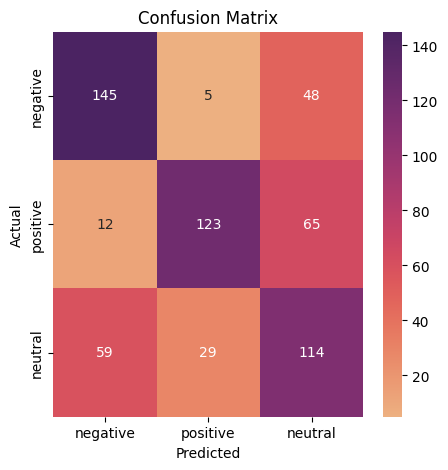

In [33]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure
plt.figure(figsize=(5, 5))

# Use Seaborn's heatmap to plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='flare', cbar=True,
            xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [21]:
result = []
for i in range(len(y_test)):
    if y_pred[i] == y_test[i]:
        result.append('correct prediction')
    else:
        result.append('wrong prediction')


test_table =  pd.DataFrame({'actual_sentiments': y_test, 'prediction_review': y_pred, 'result': result})


In [22]:
test_table.sample(10)

,actual_sentiments,prediction_review,result
275,0,0,correct prediction
0,0,0,correct prediction
77,2,0,wrong prediction
92,2,2,correct prediction
135,0,2,wrong prediction
591,2,1,wrong prediction
117,0,0,correct prediction
450,0,0,correct prediction
456,2,2,correct prediction
314,1,0,wrong prediction


In [23]:
print("correct prediction",test_table[test_table.result == 'correct prediction']['result'].count())
print("wrong prediction",test_table[test_table.result == 'wrong prediction']['result'].count())

correct prediction 382
wrong prediction 218


In [24]:
## checking predtion:

comment = "the airpalne got crack on the WINDOW seat are not comfortable"

In [25]:
## from nltk import stopwords
from nltk.corpus import stopwords

## from nltk importing WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

## downloading pre define list, we can make customized one
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Get the list of unique English stopwords
stop_words_eng = set(stopwords.words('english'))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [26]:
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

def sentiment_of_comment(text):
    try:
        tweet = []
        text = text.lower()
        split_text = word_tokenize(text)  # Use nltk's word_tokenize for tokenization

        for j in split_text:
            if j not in stop_words_eng:
                base_form = lemmatizer.lemmatize(j, pos='v')
                tweet.append(base_form)
            else:
                pass

        clean_text = ' '.join(tweet)
        token_word = tokenizer.texts_to_sequences([clean_text])  # Tokenize the clean text
        token_word = pad_sequences(token_word, maxlen=max_seq_length, padding='post')  # Pad the sequences

        prediction = model_sentiments.predict(token_word)
        pred_class = np.argmax(prediction)
        comment_list = ['negative', 'positive', 'neutral']

        return comment_list[pred_class]


    except Exception as e:
        raise Exception(e)



In [27]:
# Test the process function
comment = "while flying passangers situation become bad when one engine failed"
sentiment = sentiment_of_comment(comment)
print(sentiment)

1/1 [==============================] - 0s 18ms/step
negative


---
---